In [162]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches 
import numpy as np
import math

In [163]:
def find_steady_peak_threshold(axial_distance, data,
                               peak_height_fraction=0.85,
                               smoothing_window=21, smoothing_order=2,
                               min_width_points=10):
    """
    Finds the steady portion based on proximity to the peak height.

    Parameters:
        axial_distance (np.ndarray): Axial distance data.
        data (np.ndarray): Data to analyze.
        peak_height_fraction (float): Fraction of peak height to use as threshold (e.g., 0.9 for 90%).
        smoothing_window (int): Window size for Savitzky-Golay filter for peak finding.
        smoothing_order (int): Polynomial order for Savitzky-Golay filter.
        min_width_points (int): Minimum number of points required for a valid steady region.

    Returns:
        dict or None: Dictionary with 'steady_start_idx', 'steady_end_idx',
                      'steady_average', etc., or None if no valid region found.
    """
    if len(data) < smoothing_window:
        print("Warning: Data length is smaller than smoothing window.")
        # Optionally handle this case, e.g., return None or skip smoothing
        smoothed_data = data
    else:
        smoothed_data = savgol_filter(data, window_length=smoothing_window, polyorder=smoothing_order)

    # Find the peak within the smoothed data
    try:
        peak_idx = np.argmax(smoothed_data)
        peak_val = smoothed_data[peak_idx]
    except ValueError: # Handle empty or all-NaN data
        print("Error: Could not find peak in data.")
        return None


    # Define the threshold based on the peak value
    threshold = peak_val * peak_height_fraction

    # Find all indices where the smoothed data is above the threshold
    above_threshold_indices = np.where(smoothed_data >= threshold)[0]

    if len(above_threshold_indices) == 0:
        print(f"No points found above {peak_height_fraction*100:.1f}% of peak height.")
        return None

    # Find the contiguous block of indices that includes the peak index
    # Split the indices into contiguous blocks
    blocks = np.split(above_threshold_indices, np.where(np.diff(above_threshold_indices) != 1)[0]+1)

    steady_block = None
    for block in blocks:
        if block[0] <= peak_idx <= block[-1]:
            steady_block = block
            break

    if steady_block is None or len(steady_block) < min_width_points :
        print(f"No suitable contiguous block found around peak (min width: {min_width_points}).")
        return None

    steady_start_idx = steady_block[0]
    steady_end_idx = steady_block[-1] # This is INCLUSIVE

    # Calculate average using ORIGINAL data in the found range
    steady_data_orig = data[steady_start_idx : steady_end_idx + 1]
    steady_axial_orig = axial_distance[steady_start_idx : steady_end_idx + 1]
    steady_average = np.mean(steady_data_orig)

    return {
        "steady_start_idx": steady_start_idx,
        "steady_end_idx": steady_end_idx + 1, # Make exclusive for consistency with slicing
        "steady_average": steady_average,
        "steady_axial": steady_axial_orig,
        "steady_data": steady_data_orig,
        "peak_idx": peak_idx,
        "threshold": threshold
    }


# --- Helper Function for Dynamic Limits ---
def calculate_dynamic_limits(data_arrays, padding_factor=0.05, round_multiple=None, zero_baseline=False):
    if not isinstance(data_arrays, list):
        data_arrays = [data_arrays]
    all_data = np.concatenate([arr[np.isfinite(arr)] for arr in data_arrays if hasattr(arr, 'size') and arr.size > 0])
    if all_data.size == 0:
        return (0, 1) if not zero_baseline else (-0.5, 0.5)
    data_min, data_max = np.min(all_data), np.max(all_data)
    if np.isclose(data_min, data_max):
        delta = abs(data_min) * 0.1 if not np.isclose(data_min, 0) else 0.1
        data_range = delta * 2; data_min -= delta; data_max += delta
    else: data_range = data_max - data_min
    padding = data_range * padding_factor
    lim_min, lim_max = data_min - padding, data_max + padding
    if zero_baseline:
        if lim_min > 0: lim_min = 0
        elif lim_max < 0: lim_max = 0
    if round_multiple is not None and round_multiple > 0:
        lim_min = math.floor(lim_min / round_multiple) * round_multiple
        lim_max = math.ceil(lim_max / round_multiple) * round_multiple
        if np.isclose(lim_max, lim_min):
             lim_min -= round_multiple / 2; lim_max += round_multiple / 2
    return lim_min, lim_max


In [164]:
# Load the file

### These 2 are problematic as it could not detect the edges
# data_file = Path("../Data/0.8mpers-60n-0.8pas.xlsx") # Change this to the appropriate folder/file
# data_file = Path(r"E:\School\Year 3\cheng_lab\Data\0.3mpers-110n-11.3pas.xlsx") 

# data_file = Path("../Data/1.5mpers-30n-11.3pas.xlsx") 
# data_file = Path("../Data/3kn-0.5.xlsx")

data_file = Path(r"..\Data\1mpers-20n-0.8pas.xlsx")
df = pl.read_excel(source=data_file, sheet_name="Analog")

# df = pl.read_excel(source=data_file, sheet_name="Analog #1")

In [165]:
## Parameter you can change
sampling_speed = 1000
speed = 1.5
data_point_length = speed / sampling_speed

In [166]:
## Process the file
header_names = df.columns
x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
df = df.with_columns(
    x_data,
    ((16+pl.col("Voltage")) * 1000).alias("Left Gap [\u03bcm]"),
    ((16+((pl.col("Dev1/ai3")/250*1000)-4)*(10/16))*1000).alias("Right Gap [\u03bcm]"),
    (pl.col("Dev1/ai2")*112.3898+558.30904).alias("Load [N]")
)

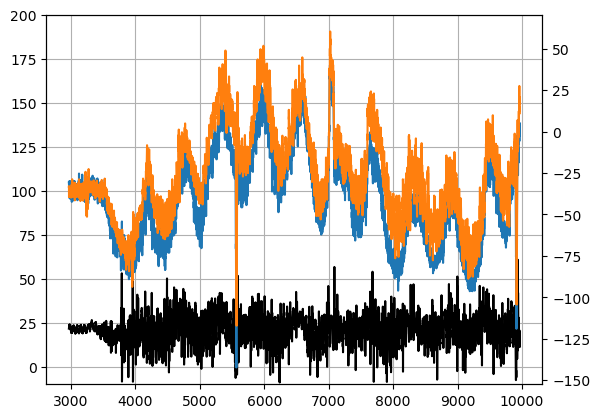

In [167]:
## Ideal Plot of What We Want

# zero_point = 7000
zero_point = 6467 ## 0.8
# # zero_point = 13950 ## 0.5
# zero_point = 24065  ## This is for 0.3
fig, ax1 = plt.subplots()
bound = 3500
test_index = np.arange(0, df.shape[0])
ax1.plot(test_index[zero_point-bound:zero_point+bound], df["Load [N]"][zero_point-bound:zero_point+bound] - np.mean(df.select("Load [N]").head(100).to_numpy()), c='k')
ax1.set_ylim(-10, 200)
ax1.grid()

ax2 = ax1.twinx()

ax2.plot(test_index[zero_point-bound:zero_point+bound], df["Left Gap [\u03bcm]"][zero_point-bound:zero_point+bound] - df["Left Gap [μm]"][zero_point])
ax2.plot(test_index[zero_point-bound:zero_point+bound], df["Right Gap [\u03bcm]"][zero_point-bound:zero_point+bound] - df["Right Gap [μm]"][zero_point])

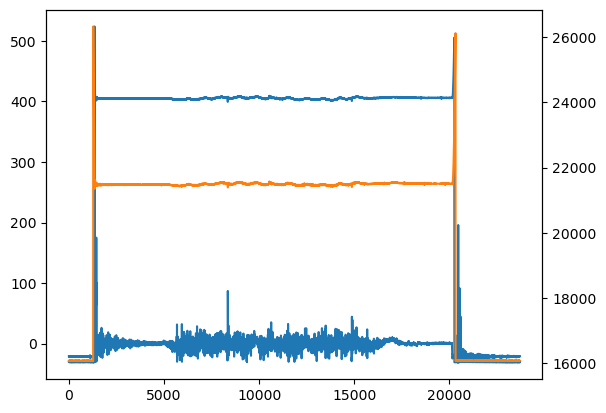

In [168]:
fig, ax1 = plt.subplots()
x_data
ax1.plot(x_data, df["Load [N]"])

ax2 = ax1.twinx()

ax2.plot(x_data, df["Left Gap [\u03bcm]"])
ax2.plot(x_data, df["Right Gap [\u03bcm]"])
signal_data = df["Right Gap [\u03bcm]"]
plt.savefig(f'{data_file}.png')
# display(signal_data)

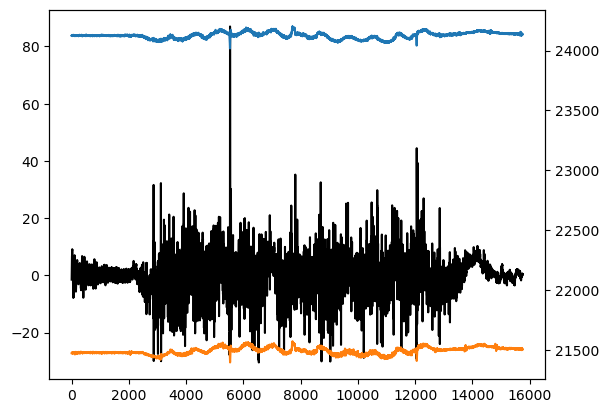

In [169]:
bound = 1000
left_gap = df["Left Gap [μm]"].to_numpy()
peaks, _ = find_peaks(left_gap)

peaks = sorted(peaks, key=lambda x: left_gap[x], reverse=True)
outlier_index = np.sort(peaks[:2]) # Sort ensures the 0 index is the left point 

start_index, end_index = outlier_index[0] + bound, outlier_index[1] - bound * 3 # Take the bound away from the file

fig, ax1 = plt.subplots()

df = df.slice(start_index, end_index) 

x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
ax1.plot(x_data, df["Load [N]"], color='k')

ax2 = ax1.twinx()

ax2.plot(x_data, df["Left Gap [\u03bcm]"])
ax2.plot(x_data, df["Right Gap [\u03bcm]"])
save_path =  data_file.parent / Path('Cut') / f"{data_file.name}.png"
plt.savefig(save_path)

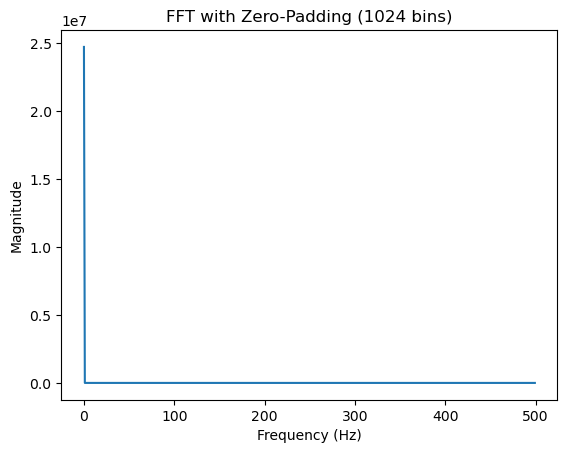

In [170]:
import scipy.fft as fft
N = 2**10
fs = 1000
signal_data = df["Left Gap [\u03bcm]"]
signal_data = np.asarray(signal_data, dtype=np.float64)
fft_values = fft.fft(signal_data, N)
frequencies = fft.fftfreq(N, d=1/fs)

freqs, amplitudes = frequencies[:N//2], np.abs(fft_values[:N//2])

plt.plot(freqs, amplitudes)
plt.title("FFT with Zero-Padding (1024 bins)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
# plt.xlim([0,10])
plt.show()


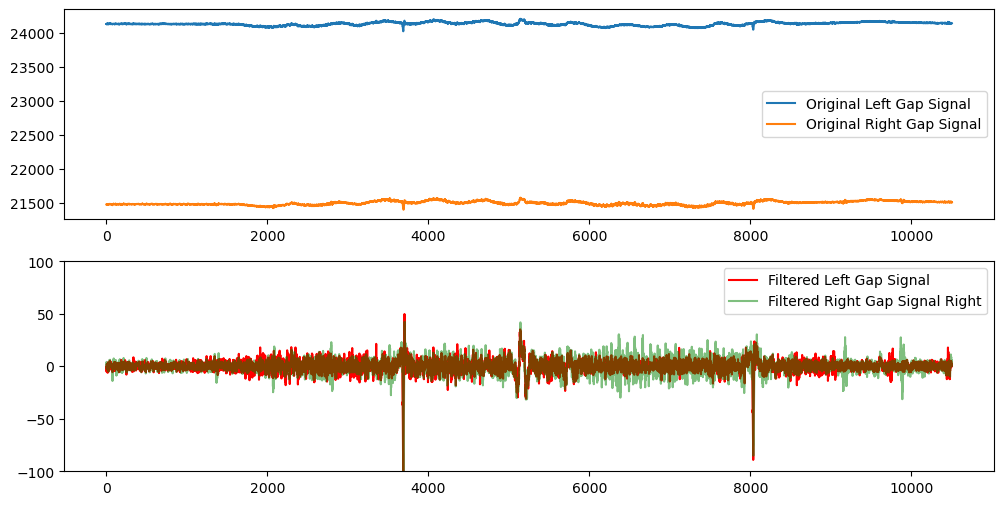

In [171]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Add impulse to the signal
noisy_signal = signal_data
right_signal = df["Right Gap [\u03bcm]"]

# Design a High-Pass Butterworth Filter
cutoff_freq = 5   # Remove frequencies below 5 Hz
order = 4
b, a = signal.butter(order, cutoff_freq / (fs / 2), btype='high')
# Apply the filter
filtered_signal = signal.filtfilt(b, a, noisy_signal)
filtered_right_signal = signal.filtfilt(b, a, right_signal)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(noisy_signal, label="Original Left Gap Signal")
plt.plot(right_signal, label="Original Right Gap Signal")
# plt.ylim([-100,100])
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(filtered_signal, label="Filtered Left Gap Signal", color="r")
plt.plot(filtered_right_signal, label="Filtered Right Gap Signal Right", color="g", alpha=0.5)
plt.ylim([-100,100])
plt.legend()
plt.show()

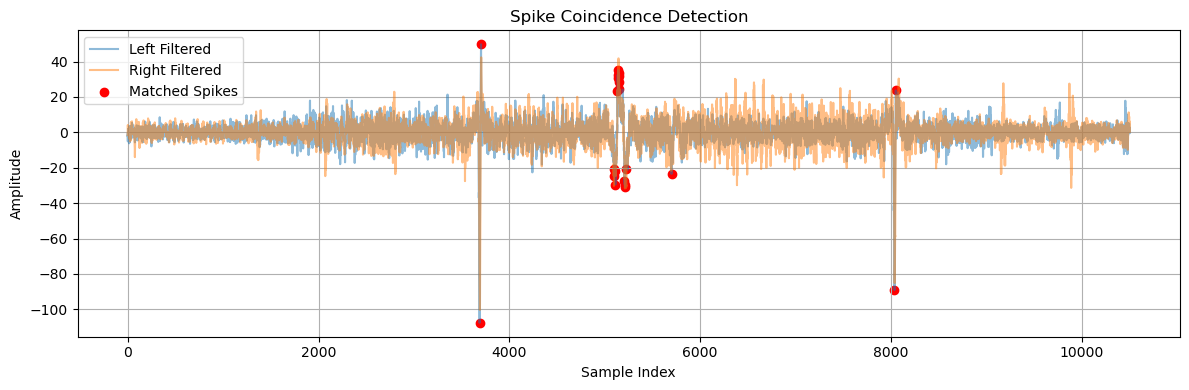

In [172]:
from scipy.signal import find_peaks

# Detect positive and negative peaks
left_peaks, _ = find_peaks(filtered_signal, height=20)  # adjust height
left_troughs, _ = find_peaks(-filtered_signal, height=20)
right_peaks, _ = find_peaks(filtered_right_signal, height=20)
right_troughs, _ = find_peaks(-filtered_right_signal, height=20)

# Combine peaks and troughs for both
left_spikes = np.sort(np.concatenate([left_peaks, left_troughs]))
right_spikes = np.sort(np.concatenate([right_peaks, right_troughs]))

# Compare: check for matching spikes within a small lag tolerance
tolerance = 5  # samples
matches = []

for i in left_spikes:
    if np.any(np.abs(right_spikes - i) <= tolerance):
        matches.append(i)

# Plot spike matches
plt.figure(figsize=(12, 4))
plt.plot(filtered_signal, label="Left Filtered", alpha=0.5)
plt.plot(filtered_right_signal, label="Right Filtered", alpha=0.5)
plt.scatter(matches, filtered_signal[matches], color='red', label="Matched Spikes")
plt.title("Spike Coincidence Detection")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Most active window: 4750 to 5250 with 16 matched spikes.


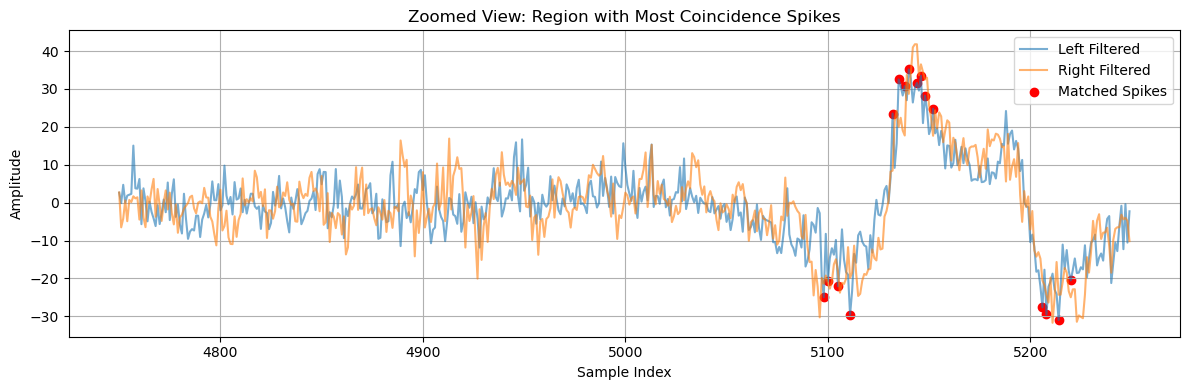

In [173]:
# Parameters
window_size = 500  # Number of samples per window (adjust if needed)

# Count matched spikes in sliding windows
match_counts = []
window_starts = range(0, len(filtered_signal) - window_size + 1, 50)  # Slide every 50 samples

for start in window_starts:
    end = start + window_size
    count = np.sum((np.array(matches) >= start) & (np.array(matches) < end))
    match_counts.append(count)

# Find the window with the most matched spikes
best_window_index = np.argmax(match_counts)
best_start = window_starts[best_window_index]
best_end = best_start + window_size

print(f"Most active window: {best_start} to {best_end} with {match_counts[best_window_index]} matched spikes.")

# Plot zoomed-in region
plt.figure(figsize=(12, 4))
plt.plot(range(best_start, best_end), filtered_signal[best_start:best_end], label="Left Filtered", alpha=0.6)
plt.plot(range(best_start, best_end), filtered_right_signal[best_start:best_end], label="Right Filtered", alpha=0.6)

# Plot only matched spikes in this region
matched_in_window = [i for i in matches if best_start <= i < best_end]
plt.scatter(matched_in_window,
            filtered_signal[matched_in_window],
            color='red', label="Matched Spikes")

plt.title("Zoomed View: Region with Most Coincidence Spikes")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [174]:
import numpy as np # Make sure numpy is imported if not already
import polars as pl # Make sure polars is imported if not already
import math # For ceil
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector

def get_manual_indices_interactive(dataframe, title_prefix="Select Data Region"):
    """
    Displays a simplified plot with Load on left Y, Gaps on right Y,
    and allows the user to select a start and end index by drawing a
    horizontal span on Axial Distance.

    Args:
        dataframe (pl.DataFrame): The Polars DataFrame containing the data.
                                  Must contain "Axial Distance [mm]", "Load [N]",
                                  "Left Gap [μm]", and "Right Gap [μm]".
        title_prefix (str): Prefix for the plot window title.

    Returns:
        tuple: (start_index, end_index) or (None, None) if selection is aborted.
    """
    # --- Define column names ---
    x_col = "Axial Distance [mm]"
    load_col = "Load [N]"
    left_gap_col = "Left Gap [μm]"
    right_gap_col = "Right Gap [μm]"

    # --- Check if necessary columns exist ---
    required_cols = [x_col, load_col, left_gap_col, right_gap_col]
    for col in required_cols:
        if col not in dataframe.columns:
            print(f"ERROR: Required column '{col}' not found in DataFrame. Cannot create plot.")
            return None, None

    # --- Prepare data ---
    x_plot_data = dataframe[x_col].to_numpy()
    load_data = dataframe[load_col].to_numpy()
    left_gap_data = dataframe[left_gap_col].to_numpy()
    right_gap_data = dataframe[right_gap_col].to_numpy()

    x_data_for_indices = x_plot_data  # For np.searchsorted

    # --- Create Figure and Axes ---
    fig, ax_load = plt.subplots(figsize=(12, 6)) # Main axes for Load
    ax_gaps = ax_load.twinx()                    # Twin axes for Gaps

    # --- Plotting ---
    line_load, = ax_load.plot(x_plot_data, load_data, color='black', label=load_col)
    line_left_gap, = ax_gaps.plot(x_plot_data, left_gap_data, color='blue', label=left_gap_col, linestyle='--')
    line_right_gap, = ax_gaps.plot(x_plot_data, right_gap_data, color='red', label=right_gap_col, linestyle=':')

    # --- Axis Labels ---
    ax_load.set_xlabel(x_col)
    ax_load.set_ylabel(load_col, color='black')
    ax_gaps.set_ylabel("Gap Values (μm)", color='dimgray') # General label for the right axis

    # --- Tick Colors ---
    ax_load.tick_params(axis='y', labelcolor='black')
    ax_gaps.tick_params(axis='y', labelcolor='dimgray')

    # --- Legend ---
    # Collect lines and labels from both axes for a single legend
    lines = [line_load, line_left_gap, line_right_gap]
    labels = [l.get_label() for l in lines]
    ax_load.legend(lines, labels, loc='best')

    # --- Title ---
    # Using fig.suptitle for the main instruction, ax_load.set_title for selection feedback
    fig.suptitle(f"{title_prefix}\nDrag on '{x_col}' to select. Close window when done.", fontsize=12)
    ax_load.set_title("", fontsize=10) # Placeholder for selection feedback
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle

    # --- SpanSelector Logic ---
    selected_region_indices = {"start": None, "end": None}

    def onselect(xmin_sel, xmax_sel):
        start_idx = np.searchsorted(x_data_for_indices, xmin_sel, side='left')
        end_idx = np.searchsorted(x_data_for_indices, xmax_sel, side='right')
        start_idx = max(0, start_idx)
        end_idx = min(len(x_data_for_indices), end_idx)

        if start_idx < end_idx:
            selected_region_indices["start"] = start_idx
            selected_region_indices["end"] = end_idx
            feedback_msg = f"Selected: Idx {start_idx}-{end_idx-1} (X: {xmin_sel:.2f} to {xmax_sel:.2f})"
            ax_load.set_title(feedback_msg, color='green', fontsize=10)
            print(feedback_msg)
            fig.canvas.draw_idle()
        else:
            ax_load.set_title("Selection invalid. Try again.", color='red', fontsize=10)
            print("Selection too small or invalid.")
            fig.canvas.draw_idle()

    span = SpanSelector(ax_load, onselect, 'horizontal', useblit=False,
                        props=dict(alpha=0.3, facecolor='lightgray'), # Simple rectangle for selection
                        button=1)

    fig._span_selector_ref = span

    plt.show(block=True)

    if selected_region_indices["start"] is not None and selected_region_indices["end"] is not None:
        print(f"Final selection: Start Index = {selected_region_indices['start']}, End Index = {selected_region_indices['end']}")
        return selected_region_indices["start"], selected_region_indices["end"]
    else:
        print("No valid selection made, or window closed before selection.")
        return None, None


In [175]:

import numpy as np
from scipy.signal import find_peaks
import math # For ceil

# === Parameters for Bump Detection ===
window_size = 100
step_size = 10
min_spike_count_density = 5 # Threshold for find_peaks on density
peak_prominence = 10       # Prominence for find_peaks on density
min_peak_distance_samples = 200
density_boundary_fraction = 0.2 # Fraction of peak density height for boundary search

# === 1. Calculate Spike Density (Unchanged) ===
match_counts = []
matches = np.array(matches) # Ensure numpy array
window_starts = range(0, len(filtered_signal) - window_size, step_size)
window_centers = []

for start in window_starts:
    end = start + window_size
    count = np.sum((matches >= start) & (matches < end))
    match_counts.append(count)
    window_centers.append(start + window_size // 2)

match_counts = np.array(match_counts)
window_centers = np.array(window_centers)

# === 2. Find ALL Peaks in Density Initially (Unchanged) ===
min_peak_distance_windows = int(np.ceil(min_peak_distance_samples / step_size))
density_peaks_indices, properties = find_peaks(
    match_counts,
    height=min_spike_count_density,
    prominence=peak_prominence,
    distance=min_peak_distance_windows
)

print(f"Found {len(density_peaks_indices)} potential density peaks initially.")

# === 3. Calculate Boundaries and Actual Spike Counts for ALL Peaks ===
preliminary_bumps = [] # Store info before sorting and overlap check

if len(density_peaks_indices) > 0:
    peak_heights = properties.get('peak_heights', None) # Get heights if available

    for i, peak_idx in enumerate(density_peaks_indices):
        peak_height = match_counts[peak_idx] # Use actual count at peak index

        # Find boundaries based on density drop
        left_idx = peak_idx
        boundary_threshold = peak_height * density_boundary_fraction
        while left_idx > 0 and match_counts[left_idx - 1] >= boundary_threshold:
             left_idx -= 1
        right_idx = peak_idx
        while right_idx < len(match_counts) - 1 and match_counts[right_idx + 1] >= boundary_threshold:
             right_idx += 1

        # Define search region and find spikes
        search_start_signal = window_starts[left_idx]
        search_end_signal = window_starts[right_idx] + window_size
        spikes_in_bump_region = matches[(matches >= search_start_signal) & (matches < search_end_signal)]
        num_spikes_in_region = len(spikes_in_bump_region)

        # Store preliminary info ONLY if spikes were actually found
        if num_spikes_in_region > 0:
            bump_start_idx = np.min(spikes_in_bump_region)
            bump_end_idx = np.max(spikes_in_bump_region) # Inclusive end
            bump_center_idx = int(np.median(spikes_in_bump_region))

            preliminary_bumps.append({
                 'start': bump_start_idx,
                 'end': bump_end_idx + 1, # Make exclusive
                 'center': bump_center_idx,
                 'num_spikes': num_spikes_in_region, # The crucial metric
                 'peak_height': peak_height, # Original density peak height
                 'density_peak_idx': peak_idx, # Original density peak index
                 'search_start': search_start_signal, # Keep for debugging maybe
                 'search_end': search_end_signal
             })
        else:
            print(f" -> Density Peak at index {peak_idx} (height {peak_height:.1f}) yielded no actual spikes in region {search_start_signal}-{search_end_signal}.")

else:
    print("No density peaks found meeting the initial criteria.")


# === 4. Sort Preliminary Bumps by Actual Spike Count ===
if preliminary_bumps:
    # Sort by 'num_spikes' in descending order
    sorted_preliminary_bumps = sorted(preliminary_bumps, key=lambda item: item['num_spikes'], reverse=True)
    print(f"\nProcessed {len(sorted_preliminary_bumps)} potential bumps with actual spikes. Now checking overlaps...")
else:
    sorted_preliminary_bumps = []
    print("\nNo potential bumps with actual spikes found.")

# === 5. Filter Overlapping Bumps (Prioritizing higher spike counts) ===
detected_bumps = [] # This will be the final list

for potential_bump in sorted_preliminary_bumps:
    is_overlapping = False
    # Compare potential_bump against bumps already added to detected_bumps
    for existing_bump in detected_bumps:
        # Check for overlap: max(starts) < min(ends)
        # Use potential_bump['end'] (exclusive) and existing_bump['end'] (exclusive)
        if max(potential_bump['start'], existing_bump['start']) < min(potential_bump['end'], existing_bump['end']):
             is_overlapping = True
             print(f" -> Bump {potential_bump['start']}-{potential_bump['end']-1} ({potential_bump['num_spikes']} spikes) overlaps with kept bump {existing_bump['start']}-{existing_bump['end']-1}. Skipping.")
             break # Stop checking overlaps for this potential_bump

    # If it doesn't overlap with any already kept bumps, add it
    if not is_overlapping:
        detected_bumps.append(potential_bump)
        print(f" -> Keeping Bump: {potential_bump['start']}-{potential_bump['end']-1} ({potential_bump['num_spikes']} spikes)")


# --- Final Result ---
# 'detected_bumps' now contains non-overlapping bumps.
# Because we processed the sorted list and added non-overlapping ones,
# the bump with the globally highest spike count (among non-overlapping ones)
# should naturally be at index 0.

if detected_bumps:
    print(f"\nFinal detected non-overlapping bumps: {len(detected_bumps)}")
    # The first element IS the best bump based on spike count due to sorting before filtering
    print(f"Best bump (Index 0): Start={detected_bumps[0]['start']}, End={detected_bumps[0]['end']-1}, Center={detected_bumps[0]['center']}, Num Spikes={detected_bumps[0]['num_spikes']}")
    
    start_index, end_index = detected_bumps[0]["start"], detected_bumps[0]["end"]
    # Optionally print other bumps
    # for i, bump in enumerate(detected_bumps[1:], 1):
    #    print(f"Bump {i+1}: Start={bump['start']}, End={bump['end']-1}, Center={bump['center']}, Num Spikes={bump['num_spikes']}")
else:
    print("\nNo valid, non-overlapping bumps were detected. going to manual mode")
    # Call manual mode here
    start_index, end_index = get_manual_indices_interactive(df)

Found 1 potential density peaks initially.

Processed 1 potential bumps with actual spikes. Now checking overlaps...
 -> Keeping Bump: 5098-5220 (16 spikes)

Final detected non-overlapping bumps: 1
Best bump (Index 0): Start=5098, End=5220, Center=5142, Num Spikes=16


In [176]:

# average_force = np.mean(np.array(df["Load [N]"][:1000]))

# df_filtered = df.with_columns(
#     pl.col("Load [N]") - average_force,
#     pl.col("Axial Distance [mm]") - df["Axial Distance [mm]"].item(start_index),
#     pl.col("Left Gap [μm]") - df["Left Gap [μm]"].item(start_index),
#     pl.col("Right Gap [μm]") - df["Right Gap [μm]"].item(start_index)
# )


Processing data for selected indices: 5098 to 5220
Analyzing steady portions...

Analysis Successful for selected region:
  Left Gap Average: 78.82
  Right Gap Average: 80.14


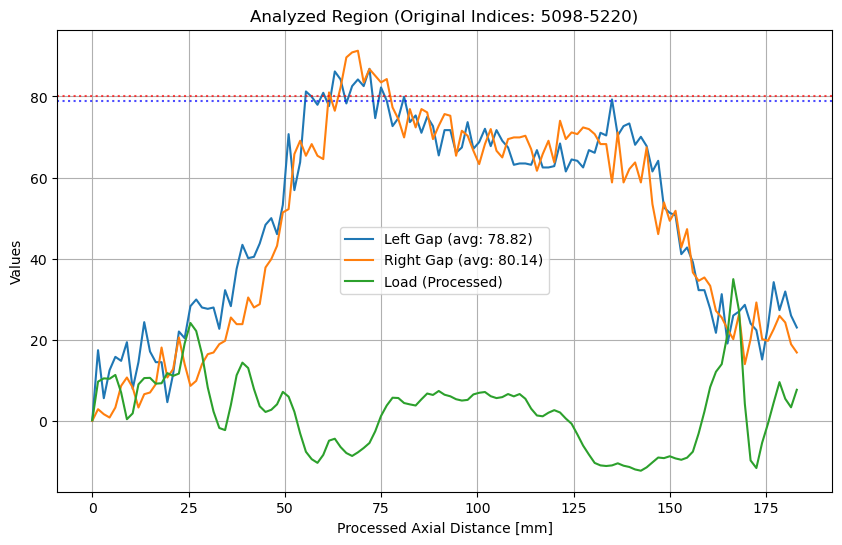


Processing finished successfully.


In [177]:
# --- Main Analysis Loop ---
analysis_successful = False

while not analysis_successful:
    # --- Step 1: Get/Update Selection Indices ---
    if start_index is None or end_index is None: # Or if a retry is explicitly needed
        print("\n--- Entering Manual Selection Mode ---")
        # Call your interactive selection function (ensure it's defined)
        # For this example, I'm using the simplified one.
        s_idx, e_idx = get_manual_indices_interactive(df, title_prefix="Select Region for Analysis")

        if s_idx is None or e_idx is None:
            print("User cancelled selection. Exiting analysis.")
            break # Exit the while loop entirely
        
        # Validate selection before assigning
        if e_idx <= s_idx:
            print(f"Invalid selection: end_index ({e_idx}) must be greater than start_index ({s_idx}). Please try again.")
            # Reset start/end_index to None to re-trigger selection in the next loop iteration
            start_index, end_index = None, None
            continue # Go to the start of the while loop
        
        start_index, end_index = s_idx, e_idx
        print(f"Region selected: Indices {start_index} to {end_index-1}")


    # --- Step 2: Prepare Data Based on Current start_index and end_index ---
    print(f"\nProcessing data for selected indices: {start_index} to {end_index-1}")
    
    # Calculate average_force (e.g., from the start of the original df)
    # Ensure there are enough points for the mean calculation
    avg_force_calc_len = min(1000, len(df))
    average_force = 0
    if avg_force_calc_len > 0:
        average_force = np.mean(df["Load [N]"][:avg_force_calc_len].to_numpy())

    # Reference values for subtraction from the original df at the current start_index
    # These ensure that even if we re-select, the "zeroing" is relative to the new start
    try:
        ref_axial_dist = df["Axial Distance [mm]"].item(start_index)
        ref_left_gap = df["Left Gap [μm]"].item(start_index)
        ref_right_gap = df["Right Gap [μm]"].item(start_index)
    except IndexError:
        print(f"Error: start_index {start_index} is out of bounds for the DataFrame (length {len(df)}).")
        print("Please try selecting a valid region.")
        start_index, end_index = None, None # Force re-selection
        continue


    # Create a temporary DataFrame for the *selected slice* and then apply transformations
    # This avoids modifying the global `df` or `df_filtered` repeatedly in a confusing way.
    df_slice = df[start_index:end_index]

    if len(df_slice) == 0:
        print("The selected slice is empty. Please select a valid region.")
        start_index, end_index = None, None # Force re-selection
        continue

    # Apply transformations to the slice
    x_axis = (df_slice["Axial Distance [mm]"] - ref_axial_dist).to_numpy()
    left_gap = (df_slice["Left Gap [μm]"] - ref_left_gap).to_numpy()
    right_gap = (df_slice["Right Gap [μm]"] - ref_right_gap).to_numpy()
    load_data = (df_slice["Load [N]"] - average_force).to_numpy()


    # --- Step 3: Analyze Steady Portions ---
    print("Analyzing steady portions...")
    result_left = find_steady_peak_threshold(x_axis, left_gap)
    result_right = find_steady_peak_threshold(x_axis, right_gap)

    # --- Step 4: Check Results and Decide Next Action ---
    if result_left is None or result_right is None:
        print("\n" + "="*30)
        print("Analysis Error: Could not find suitable steady portions for the selected region.")
        if result_left is None: print(" -> Problem with Left Gap.")
        if result_right is None: print(" -> Problem with Right Gap.")
        print("="*30)
        
        user_choice = input("Would you like to try selecting a different region? (y/n): ").lower()
        if user_choice == 'y':
            start_index, end_index = None, None # Reset to trigger manual_mode in the next loop
            print("Returning to manual selection mode...")
            # The loop will continue, and the condition at the start will re-trigger manual selection
        else:
            print("Exiting analysis.")
            break # Exit the while loop
    else:
        # Success! Process the results
        try:
            left_gap_avg = result_left["steady_average"]
            right_gap_avg = result_right["steady_average"]
            print(f"\nAnalysis Successful for selected region:")
            print(f"  Left Gap Average: {left_gap_avg:.2f}")
            print(f"  Right Gap Average: {right_gap_avg:.2f}")
            analysis_successful = True # Set flag to exit the loop

            # --- Step 5: Plotting (if successful) ---
            plt.figure(figsize=(10, 6))
            plt.plot(x_axis, left_gap, label=f"Left Gap (avg: {left_gap_avg:.2f})")
            plt.plot(x_axis, right_gap, label=f"Right Gap (avg: {right_gap_avg:.2f})")
            plt.plot(x_axis, load_data, label="Load (Processed)")
            plt.axhline(left_gap_avg, color='blue', linestyle=':', alpha=0.7)
            plt.axhline(right_gap_avg, color='red', linestyle=':', alpha=0.7)
            plt.xlabel("Processed Axial Distance [mm]")
            plt.ylabel("Values")
            plt.title(f"Analyzed Region (Original Indices: {start_index}-{end_index-1})")
            plt.legend()
            plt.grid(True)
            plt.show()

        except KeyError as e:
            print(f"Error: Key '{e}' not found in results from find_steady_peak_threshold.")
            print("Please check the structure of the dictionary returned by that function.")
            user_choice = input("Would you like to try selecting a different region? (y/n): ").lower()
            if user_choice == 'y':
                start_index, end_index = None, None
            else:
                print("Exiting analysis.")
                break
        except Exception as e: # Catch any other unexpected error during result processing
            print(f"An unexpected error occurred: {e}")
            user_choice = input("Would you like to try selecting a different region? (y/n): ").lower()
            if user_choice == 'y':
                start_index, end_index = None, None
            else:
                print("Exiting analysis.")
                break

# --- End of While Loop ---

if analysis_successful:
    print("\nProcessing finished successfully.")
else:
    print("\nProcessing was not completed or was aborted by the user.")

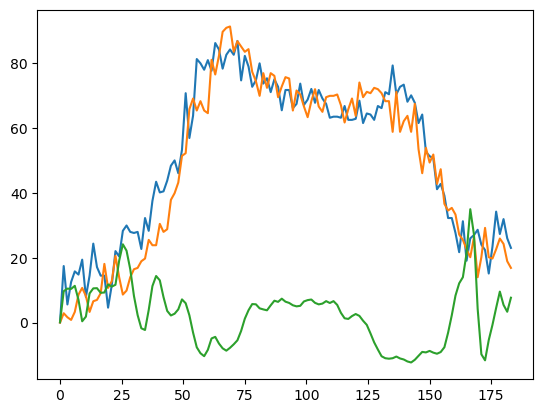

In [178]:
# x_axis = df_filtered["Axial Distance [mm]"][start_index:end_index].to_numpy()
# left_gap = df_filtered["Left Gap [μm]"][start_index:end_index].to_numpy()
# right_gap = df_filtered["Right Gap [μm]"][start_index:end_index].to_numpy()
# load_data = df_filtered["Load [N]"][start_index:end_index].to_numpy()

# # Analyze steady portions for both left_gap and right_gap
# result_left = find_steady_peak_threshold(x_axis, left_gap)
# result_right = find_steady_peak_threshold(x_axis, right_gap)

# if result_left is None or result_right is None:
#     manual_mode()
# else:
#     left_gap_avg = result_left["steady_average"]
#     right_gap_avg = result_right["steady_average"]

# left_gap_avg_range = np.arange(result_left["steady_start_idx"], result_left["steady_end_idx"])
# right_gap_avg_range = left_gap_avg_range


plt.plot(x_axis, left_gap)
plt.plot(x_axis, right_gap)
plt.plot(x_axis, load_data)

Drawing bounding box: x=55.5, width=33.0, y=61.9, height=32.1


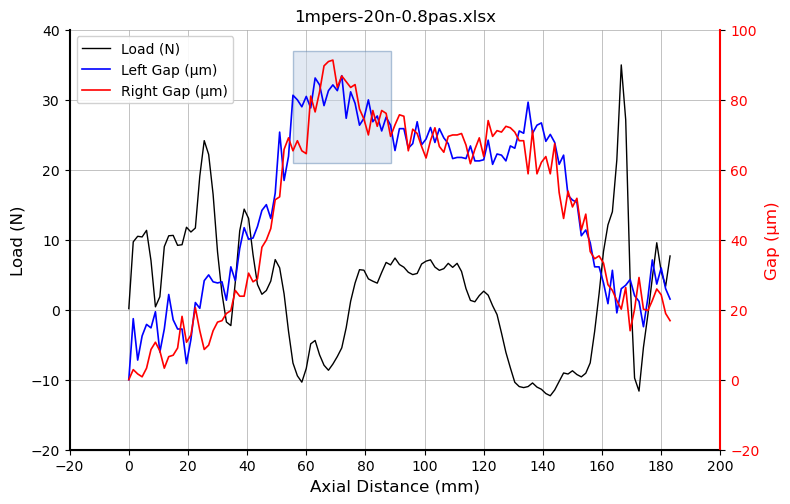

In [179]:

# --- Calculate Dynamic Limits ---
# Setting explicit rounding multiples based on the target image's style
x_lim_min, x_lim_max = calculate_dynamic_limits([x_axis], padding_factor=0.05, round_multiple=20.0)
y_load_lim_min, y_load_lim_max = calculate_dynamic_limits([load_data], padding_factor=0.05, round_multiple=10.0, zero_baseline=True)
y_gap_lim_min, y_gap_lim_max = calculate_dynamic_limits([left_gap, right_gap], padding_factor=0.05, round_multiple=20.0) # Adjust y-gap if needed

# --- Choose Tick Intervals ---
x_tick_interval = 20.0
y_load_tick_interval = 10.0
y_gap_tick_interval = 20.0 # Match y-gap rounding

# --- Determine Bounding Box Coordinates based on steady indices and data ---
box_defined = False
box_y_padding_factor = 0.1 # Padding for the box height

if ('result_left' in locals() and "steady_start_idx" in result_left and "steady_end_idx" in result_left and
    'result_right' in locals() and "steady_start_idx" in result_right and "steady_end_idx" in result_right): # Check both results

    steady_start_idx_l = result_left["steady_start_idx"]
    steady_end_idx_l = result_left["steady_end_idx"] # Exclusive
    steady_start_idx_r = result_right["steady_start_idx"]
    steady_end_idx_r = result_right["steady_end_idx"] # Exclusive

    # Check if indices are valid for BOTH left and right (or adjust logic if only one is needed)
    if (steady_start_idx_l < len(x_axis) and steady_end_idx_l <= len(x_axis) and steady_end_idx_l > steady_start_idx_l and
        steady_start_idx_r < len(x_axis) and steady_end_idx_r <= len(x_axis) and steady_end_idx_r > steady_start_idx_r):

        # --- Calculate X extent from left indices (or union/intersection if preferred) ---
        box_x_start_val = x_axis[steady_start_idx_l]
        box_x_end_val = x_axis[steady_end_idx_l - 1] # Last included point
        box_width = box_x_end_val - box_x_start_val

        # --- Calculate Y extent dynamically from data within steady ranges ---
        steady_y_left = left_gap[steady_start_idx_l:steady_end_idx_l]
        steady_y_right = right_gap[steady_start_idx_r:steady_end_idx_r]

        if steady_y_left.size > 0 and steady_y_right.size > 0:
            y_min_in_range = min(np.min(steady_y_left), np.min(steady_y_right))
            y_max_in_range = max(np.max(steady_y_left), np.max(steady_y_right))

            y_range_in_box = y_max_in_range - y_min_in_range
            y_padding = y_range_in_box * box_y_padding_factor

            box_y_min = y_min_in_range - y_padding
            box_y_max = y_max_in_range + y_padding
            box_height = box_y_max - box_y_min
            box_defined = True
        else:
            print("Warning: Empty steady range found for y-limits calculation.")
            box_x_start_val, box_width, box_y_min, box_height = 0, 0, 0, 0

    else:
        print(f"Warning: Invalid steady indices provided for bounding box.")
        box_x_start_val, box_width, box_y_min, box_height = 0, 0, 0, 0
else:
     print("Warning: 'result_left' or 'result_right' dictionary or required keys not found. Cannot draw bounding box.")
     box_x_start_val, box_width, box_y_min, box_height = 0, 0, 0, 0


# --- Create Figure and Axes ---
fig, ax_main = plt.subplots(figsize=(8, 5))
ax_twin = ax_main.twinx()

# --- Plotting Data ---
line_load, = ax_main.plot(x_axis, load_data, color='black', linewidth=1, label='Load (N)', zorder=2)
line_left, = ax_twin.plot(x_axis, left_gap, color='blue', linewidth=1.2, label='Left Gap (μm)', zorder=3)
line_right, = ax_twin.plot(x_axis, right_gap, color='red', linewidth=1.2, label='Right Gap (μm)', zorder=3)

# --- Axis Formatting with Dynamic Limits ---
# Left axis (Load)
ax_main.set_xlabel("Axial Distance (mm)", fontsize=12)
ax_main.set_ylabel("Load (N)", color='black', fontsize=12)
ax_main.set_ylim(y_load_lim_min, y_load_lim_max)
ax_main.yaxis.set_major_locator(ticker.MultipleLocator(y_load_tick_interval))
ax_main.tick_params(axis='y', labelcolor='black', labelsize=10)
ax_main.tick_params(axis='x', labelcolor='black', labelsize=10)
ax_main.spines['left'].set_color('black')
ax_main.spines['left'].set_linewidth(1.5)

# Right axis (Gaps)
ax_twin.set_ylabel("Gap (μm)", color='red', fontsize=12)
ax_twin.set_ylim(y_gap_lim_min, y_gap_lim_max)
ax_twin.yaxis.set_major_locator(ticker.MultipleLocator(y_gap_tick_interval))
ax_twin.tick_params(axis='y', labelcolor='red', labelsize=10)
ax_twin.spines['right'].set_color('red')
ax_twin.spines['right'].set_linewidth(1.5)

# X-axis
ax_main.set_xlim(x_lim_min, x_lim_max)
ax_main.xaxis.set_major_locator(ticker.MultipleLocator(x_tick_interval))
ax_main.spines['bottom'].set_color('black')
ax_main.spines['bottom'].set_linewidth(1.5)

# --- Hide Unwanted Spines ---
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)
ax_twin.spines['top'].set_visible(False)
ax_twin.spines['left'].set_visible(False)

# --- Grid lines ---
ax_main.grid(True, which='major', axis='both', linestyle='-', linewidth=0.5, color='darkgrey', zorder=0)

# --- Add Dynamic Bounding Box ---
if box_defined:
    rect = patches.Rectangle((box_x_start_val, box_y_min), # Use dynamic bottom-left corner
                             box_width,                  # Width based on steady indices
                             box_height,                 # Height based on data range + padding
                             linewidth=1, edgecolor='#6389b5', facecolor='#c7d5e8', alpha=0.5,
                             zorder=1) # zorder between grid(0) and lines(2+)
    ax_twin.add_patch(rect) # Add patch to the axis where gap data's Y scale is defined
    print(f"Drawing bounding box: x={box_x_start_val:.1f}, width={box_width:.1f}, y={box_y_min:.1f}, height={box_height:.1f}")

# --- Legend ---
lines = [line_load, line_left, line_right]
labels = [l.get_label() for l in lines]
ax_main.legend(lines, labels, loc='best', fontsize=10, facecolor='white', framealpha=0.9)

# --- Final Layout Adjustment ---
plt.tight_layout()
plt.title(f"{data_file.name}")


# --- Save The Picture ---
# --- Define Output Directory and Filenames ---
output_dir = Path("Plot_Result")
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(f"Plot_Result/{data_file.stem}.png", dpi=300)
plt.show()

In [180]:
# --- Print the requested values ---
print(f"--- Analysis Summary (Indices {start_index} to {end_index-1}) ---")
print(f"Average Left Gap [μm]: {left_gap_avg:.2f}") # Format to 2 decimal places
print(f"Average Right Gap [μm]: {right_gap_avg:.2f}") 
print(f"Average Load [N]: {average_force:.2f}")

# --- Prepare the text content for the file ---
# Use a multi-line f-string for readability
analysis_text = f"""--- Analysis Summary (Indices {start_index} to {end_index-1}) ---
Average Left Gap [μm]: {left_gap_avg:.2f}
Average Right Gap [μm]: {right_gap_avg:.2f}
Average Load [N]: {average_force:.2f}
"""


plot_filename = f"{data_file.stem}.png"
txt_filename = f"{data_file.stem}.txt" # Text file with same stem, .txt extension

plot_filepath = output_dir / plot_filename
txt_filepath = output_dir / txt_filename

# --- Write the analysis results to the text file ---
try:
    with open(txt_filepath, 'w') as f:
        f.write(analysis_text)
    print(f"Analysis results saved to: {txt_filepath}")
except Exception as e:
    print(f"Error saving analysis text file: {e}")

--- Analysis Summary (Indices 5098 to 5220) ---
Average Left Gap [μm]: 78.82
Average Right Gap [μm]: 80.14
Average Load [N]: 0.28
Analysis results saved to: Plot_Result\1mpers-20n-0.8pas.txt


In [181]:
# --- Determine Bounding Box Coordinates based on steady indices ---
# Use the indices provided by your find_steady_portion function
steady_start_idx_l = result_left["steady_start_idx"]
steady_end_idx_l = result_left["steady_end_idx"] # Assuming this index is exclusive

steady_start_idx_r = result_right["steady_start_idx"]
steady_end_idx_r = result_right["steady_end_idx"] # Assuming this index is exclusive

# Get the corresponding x-axis values for the box boundaries
# Use the union of the ranges if they differ, or stick to one (e.g., left)
# Let's use the left range for the box position for simplicity, assuming they are similar
if steady_start_idx_l < len(x_axis) and steady_end_idx_l > steady_start_idx_l:
    box_x_start_val = x_axis[steady_start_idx_l]
    # Use the index *before* the exclusive end index for the last x-value
    box_x_end_val = x_axis[steady_end_idx_l - 1]
    box_width = box_x_end_val - box_x_start_val

    # Get y-range within the identified steady portions for box height
    steady_y_left = left_gap[steady_start_idx_l:steady_end_idx_l]
    steady_y_right = right_gap[steady_start_idx_r:steady_end_idx_r] # Use right indices here

    if steady_y_left.size > 0 and steady_y_right.size > 0:
        y_min_in_range = min(np.min(steady_y_left), np.min(steady_y_right))
        y_max_in_range = max(np.max(steady_y_left), np.max(steady_y_right))
        # Add some padding to y-range for the box visually
        y_padding = (y_max_in_range - y_min_in_range) * 0.1
        box_y_min = y_min_in_range - y_padding
        box_y_max = y_max_in_range + y_padding
        box_height = box_y_max - box_y_min
        box_defined = True
    else:
        print("Warning: Empty steady range found for y-limits of bounding box.")
        box_defined = False
else:
    print("Warning: Invalid steady indices for bounding box definition.")
    box_defined = False


# --- Setup Figure Layout using GridSpec ---
fig = plt.figure(figsize=(10, 6)) # Adjust figure size as needed
# Define grid: 2 rows (table, plot+side_table), 4 columns (plot takes 3, side_table takes 1)
gs = gridspec.GridSpec(2, 4, height_ratios=[0.5, 4], width_ratios=[1, 1, 1, 1])

ax_table_top = fig.add_subplot(gs[0, :])  # Top table spans all columns
ax_main = fig.add_subplot(gs[1, 0:3])     # Main plot spans first 3 columns
ax_table_side = fig.add_subplot(gs[1, 3]) # Side table in the last column

# Create twin axis for the main plot
ax_twin = ax_main.twinx()

# --- Parameter Table (Top) ---
ax_table_top.axis('off') # Hide axes lines and ticks
# *** Replace with your actual parameter data ***
param_headers = ['Sequence', 'Liquid viscosity\n(Pa·s)', 'Load\n(N)', 'Wheel\nwidth\n(mm)',
                 'Load-to-\nwidth ratio\n(kN/m)', 'Speed\n(m/s)', 'Gap\n(μm)']
param_data = [['1.3', '1.19', '40', '20', '2', '1.5', '83.58']] # Example placeholder data
col_widths = [0.1, 0.15, 0.1, 0.1, 0.15, 0.1, 0.1]

table_top = ax_table_top.table(cellText=param_data,
                               colLabels=param_headers,
                               colWidths=col_widths,
                               cellLoc='center',
                               loc='center')
table_top.auto_set_font_size(False)
table_top.set_fontsize(8)
table_top.scale(1, 1.5) # Adjust scaling if needed

# Style top table cells
for key, cell in table_top.get_celld().items():
    cell.set_edgecolor('grey')
    if key[0] == 0: # Header row
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#1f497d') # Dark blue
    else: # Data row
        cell.set_facecolor('#dce6f1') # Light blue/grey

# --- Plotting on Main Axes ---
# Plot Load on the left axis (ax_main)
line_load, = ax_main.plot(x_axis, load_data, color='black', linewidth=0.8, label='Load (N)')
# Plot Gaps on the right axis (ax_twin)
line_left, = ax_twin.plot(x_axis, left_gap, color='blue', linewidth=1, alpha=0.8, label='Left Gap (μm)')
line_right, = ax_twin.plot(x_axis, right_gap, color='red', linewidth=1, alpha=0.8, label='Right Gap (μm)')

# --- Axis Formatting (Match the target style) ---
# Left axis (Load)
ax_main.set_xlabel("Axial Distance (mm)") # This is the normalized distance now
ax_main.set_ylabel("Load (N)", color='black')
ax_main.set_ylim(0, 200) # Set Y limits like the example plot
ax_main.yaxis.set_major_locator(ticker.MultipleLocator(10)) # Set ticks every 10 units
ax_main.tick_params(axis='y', labelcolor='black', colors='black')
ax_main.spines['left'].set_color('black')

# Right axis (Gaps)
ax_twin.set_ylabel("Gap (μm)", color='red') # Use one color for the axis label
ax_twin.set_ylim(-60, 140) # Set Y limits like the example plot
ax_twin.yaxis.set_major_locator(ticker.MultipleLocator(20)) # Set ticks every 20 units
ax_twin.tick_params(axis='y', labelcolor='red', colors='red')
ax_twin.spines['right'].set_color('red')

# X-axis
ax_main.set_xlim(-40, 140) # Set X limits like the example plot
ax_main.xaxis.set_major_locator(ticker.MultipleLocator(20)) # Set ticks every 20 units

# Grid lines (apply to main axis, will show behind twin axis plot)
ax_main.grid(True, which='major', axis='both', linestyle='-', linewidth=0.5, color='darkgrey')
ax_main.set_facecolor('white') # Ensure background is white

# --- Add Bounding Box based on your steady range ---
if box_defined:
    rect = patches.Rectangle((box_x_start_val, box_y_min), # Bottom-left corner (x, y)
                             box_width,                 # Width
                             box_height,                # Height
                             linewidth=1, edgecolor='#6389b5', facecolor='#c7d5e8', alpha=0.5, zorder=0) # Light blue box, zorder places it behind lines
    ax_twin.add_patch(rect) # Add patch to the axis where gap data is plotted

# --- Average Table (Side) ---
ax_table_side.axis('off')
avg_headers = ['Left Gap Average (μm)', 'Right Gap Average (μm)']
# Use the averages calculated by your function
avg_data = [[f"{left_gap_avg:.2f}"], [f"{right_gap_avg:.2f}"]] # Format averages

table_side = ax_table_side.table(cellText=avg_data,
                                 rowLabels=avg_headers,
                                 loc='center',
                                 colWidths=[0.8] # Single column width
                                 )
table_side.auto_set_font_size(False)
table_side.set_fontsize(9)
table_side.scale(1, 2) # Adjust scaling

# Style side table cells
for key, cell in table_side.get_celld().items():
    cell.set_edgecolor('grey')
    if key[1] == -1: # Row headers
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#1f497d')
        cell.set_height(0.1) # Make header taller
    else: # Data cell
        cell.set_facecolor('#dce6f1')
        cell.set_height(0.1) # Make data cell taller


# --- Legend ---
lines = [line_load, line_left, line_right]
labels = [l.get_label() for l in lines]
ax_twin.legend(lines, labels, loc='upper center', fontsize=8, bbox_to_anchor=(0.5, 1.0)) # Adjust legend position

# --- Adjust Layout ---
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Add rect to adjust overall margins if needed
# Adjust spacing more finely if tight_layout isn't enough
gs.update(wspace=0.6, hspace=0.2) # Adjust width and height spacing


plt.show()

NameError: name 'gridspec' is not defined

<Figure size 1000x600 with 0 Axes>

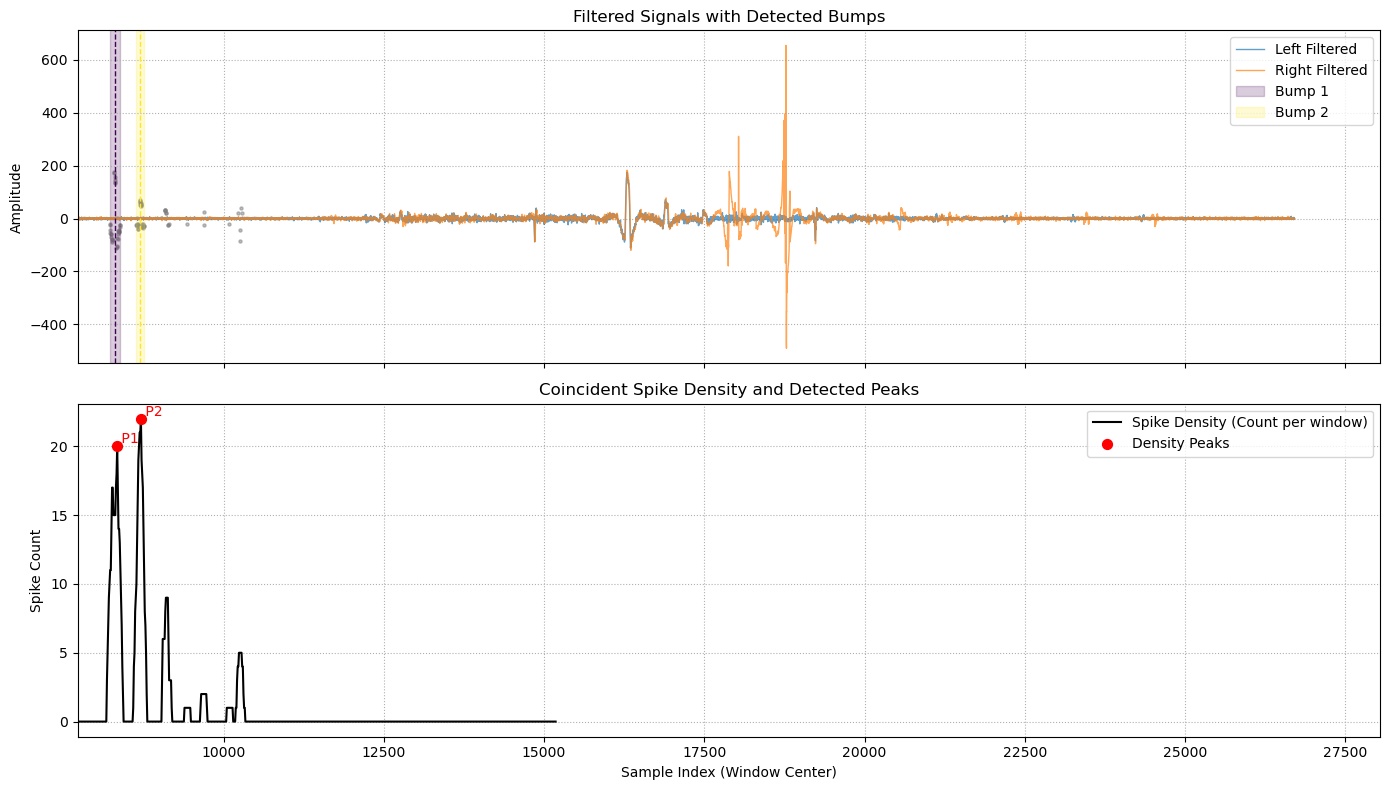

In [ ]:
# --- Plotting ---
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
x_indices = df["Axial Distance [mm]"]

# Plot 1: Signals and Detected Bumps
axs[0].plot(x_indices, filtered_signal, label="Left Filtered", alpha=0.7, lw=1)
axs[0].plot(x_indices, filtered_right_signal, label="Right Filtered", alpha=0.7, lw=1)
axs[0].scatter(matches, filtered_signal[matches], color='grey', s=5, alpha=0.5, label='_Matched Spikes (All)')

# Highlight detected bumps
colors = plt.cm.viridis(np.linspace(0, 1, max(1, len(detected_bumps))))
for i, bump in enumerate(detected_bumps):
    axs[0].axvspan(bump['start'], bump['end'], color=colors[i], alpha=0.2, label=f"Bump {i+1}")
    # Mark center derived from spikes
    axs[0].axvline(bump['center'], color=colors[i], linestyle='--', lw=1)


axs[0].set_title("Filtered Signals with Detected Bumps")
axs[0].set_ylabel("Amplitude")
axs[0].legend()
axs[0].grid(True, linestyle=':')

# Plot 2: Spike Density and Peaks
axs[1].plot(window_centers, match_counts, label="Spike Density (Count per window)", color='k', lw=1.5)
axs[1].scatter(window_centers[density_peaks_indices], match_counts[density_peaks_indices],
               color='red', s=50, zorder=5, label="Density Peaks")

# Annotate peaks
for i, peak_idx in enumerate(density_peaks_indices):
     axs[1].text(window_centers[peak_idx], match_counts[peak_idx], f" P{i+1}", verticalalignment='bottom', color='red')


axs[1].set_title("Coincident Spike Density and Detected Peaks")
axs[1].set_xlabel("Sample Index (Window Center)")
axs[1].set_ylabel("Spike Count")
axs[1].legend()
axs[1].grid(True, linestyle=':')

# Set appropriate x-limits if needed (e.g., zoom on activity region)
if detected_bumps:
    first_start = min(b['start'] for b in detected_bumps)
    last_end = max(b['end'] for b in detected_bumps)
    view_margin = 500 # Samples margin around detected bumps
    axs[0].set_xlim(max(0, first_start - view_margin))
else:
    # Fallback if no bumps detected, maybe use region from previous code?
    pass # Or plot the whole range

plt.tight_layout()
plt.show()

## Below Here Are Junk / Experimental Code

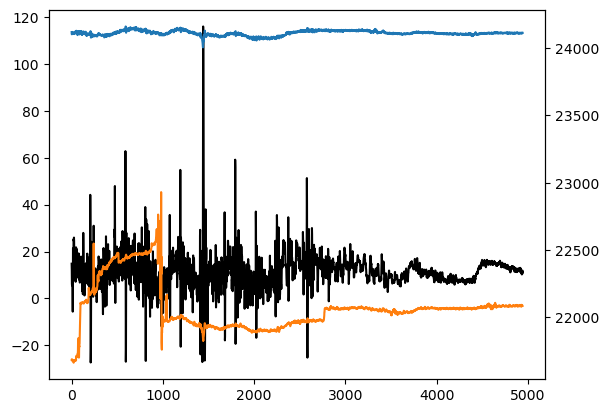

In [ ]:
bound = 1000
left_gap = df["Left Gap [μm]"].to_numpy()
peaks, _ = find_peaks(left_gap)

peaks = sorted(peaks, key=lambda x: left_gap[x], reverse=True)
outlier_index = np.sort(peaks[:2]) # Sort ensures the 0 index is the left point 

start_index, end_index = outlier_index[0] + bound, outlier_index[1] - bound *5 # Take the bound away from the file


fig, ax1 = plt.subplots()

df = df.slice(start_index, end_index) 

x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
ax1.plot(x_data, df["Load [N]"], color='k')

ax2 = ax1.twinx()

ax2.plot(x_data, df["Left Gap [\u03bcm]"])
ax2.plot(x_data, df["Right Gap [\u03bcm]"])
save_path =  data_file.parent / Path('Cut') / f"{data_file.name}.png"
plt.savefig(save_path)

In [ ]:
# Detect peaks in the filtered_left signal
peaks, properties = find_peaks(filtered_left, height=None)  # Adjust height if needed

# Get the peak heights
peak_heights = filtered_left[peaks]

# Sort peaks by height in descending order
sorted_peaks = peaks[np.argsort(peak_heights)[::-1]]

# Select the top `n` highest peaks
top_n = 2  # Change this to get more peaks if needed
highest_peaks = sorted_peaks[:top_n]

print("Highest peak indices:", highest_peaks)
print("Highest peak values:", filtered_left[highest_peaks])

# Plot results
fig, ax = plt.subplots()
ax.plot(index_array[start_index:end_index], filtered_left, label="Filtered Left Gap Signal")
ax.plot(index_array[highest_peaks], filtered_left[highest_peaks], "ro", label="Top Peaks")  # Mark highest peaks

ax.set_xlabel("Index")
ax.set_ylabel("Filtered Left Gap")
ax.legend()
plt.show()


NameError: name 'filtered_left' is not defined

C:\Users\gyang\AppData\Local\Temp\ipykernel_8544\2038824344.py:23: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian_kernel = gaussian(window_size, std_dev)


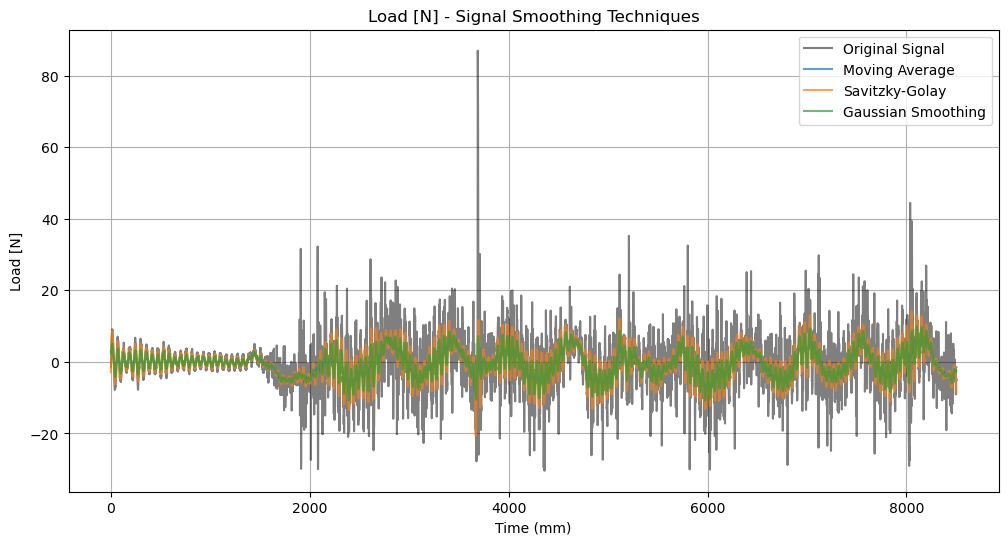

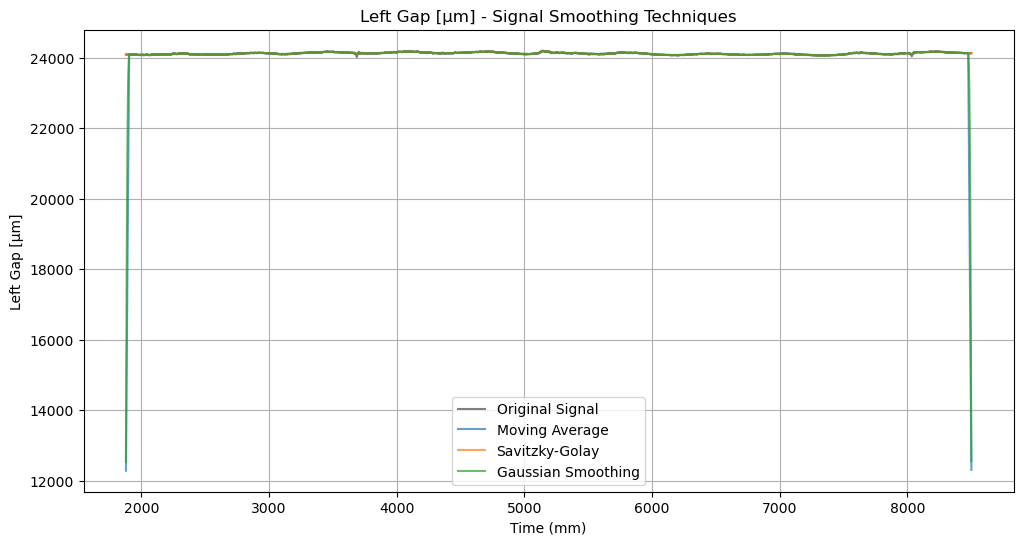

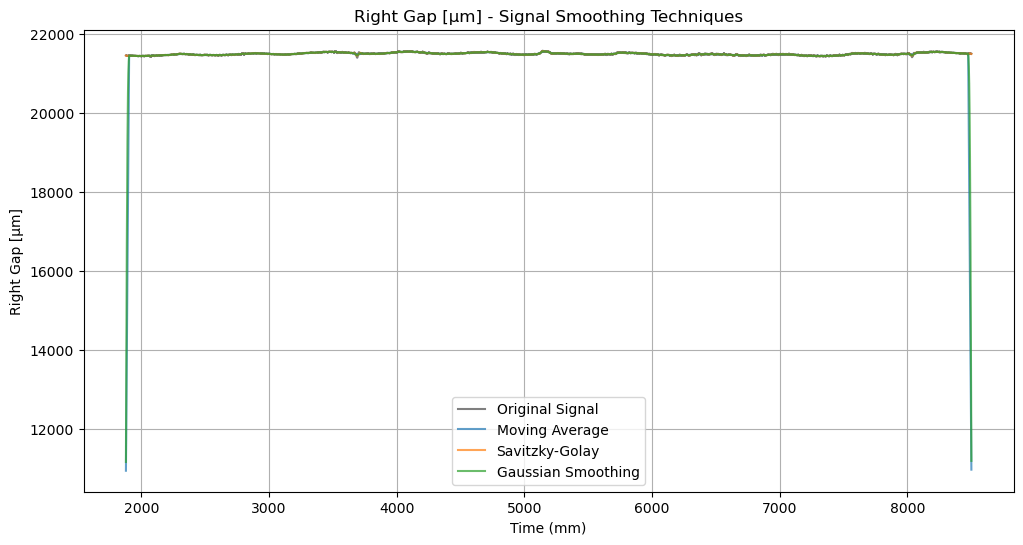

In [ ]:

from scipy.signal import savgol_filter, gaussian, convolve

# Prepare the data
x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
load = df["Load [N]"]
left_gap = df["Left Gap [μm]"]
right_gap = df["Right Gap [μm]"]

# Define smoothing parameters
window_size = 51  # Odd number for symmetric smoothing
poly_order = 3  # Polynomial order for Savitzky-Golay
std_dev = 10  # Standard deviation for Gaussian filter

# Function to smooth and plot a signal
def smooth_and_plot(signal, time, signal_label):
    # Moving Average Smoothing
    moving_avg = np.convolve(signal, np.ones(window_size)/window_size, mode='same')

    # Savitzky-Golay Filter
    savgol = savgol_filter(signal, window_length=window_size, polyorder=poly_order)

    # Gaussian Filter
    gaussian_kernel = gaussian(window_size, std_dev)
    gaussian_kernel /= np.sum(gaussian_kernel)
    gaussian_smoothed = convolve(signal, gaussian_kernel, mode='same')

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(time, signal, label="Original Signal", alpha=0.5, color="black")
    plt.plot(time, moving_avg, label="Moving Average", alpha=0.7)
    plt.plot(time, savgol, label="Savitzky-Golay", alpha=0.7)
    plt.plot(time, gaussian_smoothed, label="Gaussian Smoothing", alpha=0.7)
    plt.xlabel("Time (mm)")
    plt.ylabel(f"{signal_label}")
    plt.title(f"{signal_label} - Signal Smoothing Techniques")
    plt.legend()
    plt.grid()
    plt.show()

# Convert all signals to NumPy arrays
index_array = np.arange(0, len(x_data))
# time = x_data.to_numpy()
time = index_array
load_signal = load.to_numpy()
left_gap_signal = left_gap.to_numpy()
right_gap_signal = right_gap.to_numpy()

# Plot each signal with smoothing
smooth_and_plot(load_signal, time, "Load [N]")
smooth_and_plot(left_gap_signal[start_index:end_index], time[start_index:end_index], "Left Gap [μm]")
smooth_and_plot(right_gap_signal[start_index:end_index], time[start_index:end_index], "Right Gap [μm]")


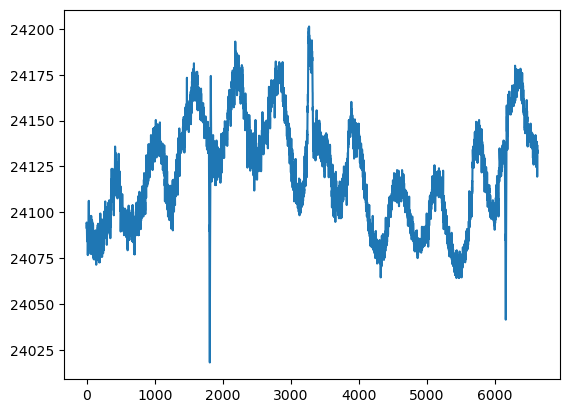

In [ ]:
plt.plot(left_gap_signal[start_index:end_index])

C:\Users\gyang\AppData\Local\Temp\ipykernel_8544\4000986316.py:22: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian_kernel = gaussian(window_size, std_dev)


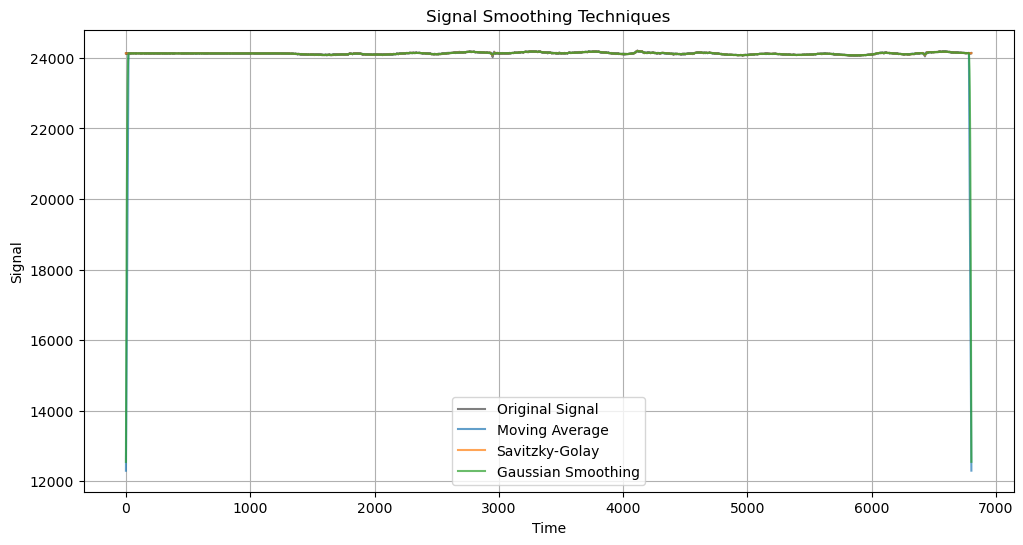

In [ ]:
from scipy.signal import savgol_filter, gaussian, convolve

x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
load = df["Load [N]"]
left_gap = df["Left Gap [μm]"]
right_gap = df["Right Gap [μm]"]

# Assuming data contains a time column and a signal column
time = x_data.to_numpy()  # Convert Polars Series to NumPy array
signal = left_gap.to_numpy()

# Moving Average Smoothing (using NumPy)
window_size = 51  # Odd number for symmetric smoothing
moving_avg = np.convolve(signal, np.ones(window_size)/window_size, mode='same')

# Savitzky-Golay Filter
poly_order = 3  # Polynomial order for fitting
savgol = savgol_filter(signal, window_length=window_size, polyorder=poly_order)

# Gaussian Filter
std_dev = 10  # Standard deviation for Gaussian filter
gaussian_kernel = gaussian(window_size, std_dev)
gaussian_kernel /= np.sum(gaussian_kernel)
gaussian_smoothed = convolve(signal, gaussian_kernel, mode='same')

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(time, signal, label="Original Signal", alpha=0.5, color="black")
plt.plot(time, moving_avg, label="Moving Average", alpha=0.7)
plt.plot(time, savgol, label="Savitzky-Golay", alpha=0.7)
plt.plot(time, gaussian_smoothed, label="Gaussian Smoothing", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("Signal Smoothing Techniques")
plt.legend()
plt.grid()
plt.show()

C:\Users\gyang\AppData\Local\Temp\ipykernel_8544\3080662804.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')


Steady portion found from index 3040 to 6390
Average Value: 24106.58


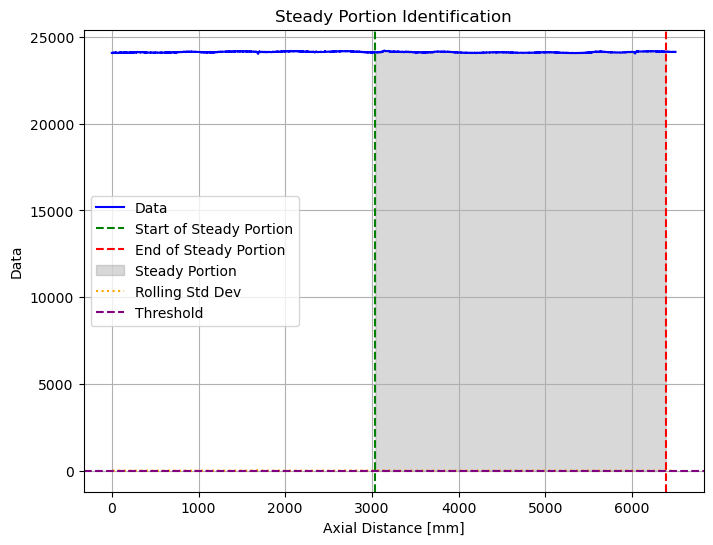

In [ ]:
def find_steady_portion(axial_distance, data, window_size=10, threshold=2):
    """
    Finds the steady portion of the data and calculates the average for that section.

    Parameters:
        axial_distance (np.ndarray): Axial distance data.
        data (np.ndarray): Data to analyze (e.g., left_gap, load, etc.).
        window_size (int): Window size for calculating the rolling standard deviation.
        threshold (float): Threshold for identifying the steady portion based on standard deviation.

    Returns:
        tuple: (start_index, end_index, average_value, steady_axial_distance, steady_data)

    Example:
        >>> start_idx, end_idx, avg, x_steady, data_steady = find_steady_portion(x, data)
    """
    # Step 1: Calculate rolling standard deviation
    rolling_std = pd.Series(data).rolling(window=window_size, center=True).std()

    # Handle NaN in rolling_std by forward/backward filling
    rolling_std = rolling_std.fillna(method='bfill').fillna(method='ffill')

    # Step 2: Identify steady-state range using the threshold
    steady_indices = rolling_std[rolling_std < threshold].index

    # Step 3: Find the start and end of the steady portion
    if len(steady_indices) > 0:
        start_idx = steady_indices[0]
        end_idx = steady_indices[-1]

        # Step 4: Filter data within this range
        steady_axial_distance = axial_distance[start_idx:end_idx+1]
        steady_data = data[start_idx:end_idx+1]

        # Compute averages
        average_value = np.mean(steady_data[0])
        return start_idx, end_idx, average_value, steady_axial_distance, steady_data
    else:
        print("No steady portion found with the given threshold.")
        return None, None, None, None, None

# Example usage
# Replace these with your actual data
left_gap = df["Left Gap [μm]"][2000:12000]
axial_distance = np.arange(0, len(left_gap))  # Example axial distance data

# Call the function
start_idx, end_idx, avg_value, steady_axial, steady_data = find_steady_portion(axial_distance, left_gap, window_size=20, threshold=2)

if start_idx is not None:
    print(f"Steady portion found from index {start_idx} to {end_idx}")
    print(f"Average Value: {avg_value:.2f}")

    # Plot the original data
    plt.figure(figsize=(8, 6))
    plt.plot(axial_distance, left_gap, label="Data", color='blue')
    plt.axvline(axial_distance[start_idx], color='green', linestyle='--', label="Start of Steady Portion")
    plt.axvline(axial_distance[end_idx], color='red', linestyle='--', label="End of Steady Portion")
    plt.fill_between(axial_distance[start_idx:end_idx+1], 
                     left_gap[start_idx:end_idx+1], 
                     alpha=0.3, color='gray', label="Steady Portion")
    
    # Overlay rolling standard deviation
    rolling_std = pd.Series(left_gap).rolling(window=20, center=True).std()
    plt.plot(axial_distance, rolling_std, color='orange', linestyle=':', label="Rolling Std Dev")
    plt.axhline(y=2, color='purple', linestyle='--', label="Threshold")
    
    plt.xlabel("Axial Distance [mm]")
    plt.ylabel("Data")
    plt.title("Steady Portion Identification")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No steady portion was identified. Adjust the threshold or window size.")

ColumnNotFoundError: "load" not found

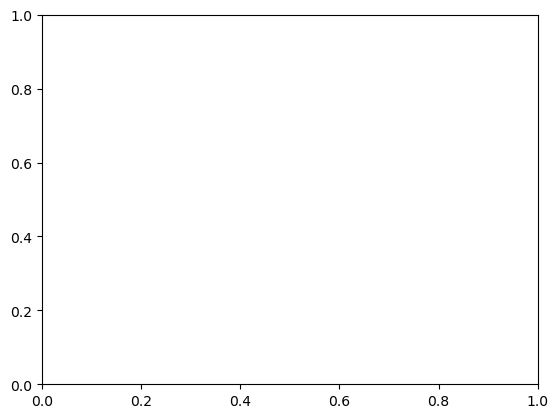

In [ ]:
fig, ax1 = plt.subplots()

x_data = x_data[start_idx:end_idx]
ax1.plot(x_data, df["load"][start_idx:end_idx])

ax2 = ax1.twinx()

ax2.plot(x_data, df["left_gap"][start_idx:end_idx])
ax2.plot(x_data, df["right_gap"][start_idx:end_idx])
plt.savefig(f'{data_file}.png')

In [ ]:

def find_offset_portion(df, bound = 200):
    # Remove the two peaks first
    left_gap = df["Left Gap [μm]"].to_numpy()
    peaks, _ = find_peaks(left_gap)

    peaks = sorted(peaks, key=lambda x: left_gap[x], reverse=True)
    outlier_index = np.sort(peaks[:2]) # Sort ensures the 0 index is the left point 

    start_index, end_index = outlier_index[0] + bound, outlier_index[1] - bound # Take the bound away from the file

    # Refining data points again
    left_gap = left_gap[start_index:end_index]
    offset_pos = start_index
    end_pos = end_index

    peaks, _ = find_peaks(left_gap)
    peak = sorted(peaks, key = lambda x : left_gap[x], reverse=True)[0]
    start_index, end_index = peak - bound, peak + bound # The area we want to analyze
    left_gap = left_gap[start_index:end_index]
    offset_pos += start_index
    end_pos = end_index

    x_range = 2 * bound
    load = df["Load [N]"][offset_pos:offset_pos+x_range].to_numpy()
    left_gap = df["Left Gap [μm]"][offset_pos:offset_pos+x_range].to_numpy()
    right_gap = df["Right Gap [μm]"][offset_pos:offset_pos+x_range].to_numpy()
    x = df["Axial Distance [mm]"][offset_pos:offset_pos+x_range].to_numpy()


    load_peaks, _ = find_peaks(load)
    zero_pos = sorted(load_peaks, key = lambda x : load[x], reverse=True)[0]

    left_gap = left_gap - left_gap[zero_pos]
    right_gap = right_gap - right_gap[zero_pos]
    x = x - x[zero_pos]

    load_offset = np.mean(df.select("Load [N]").head(100).to_numpy())
    load_no_off = load
    load = load - load_offset 
    print(load_offset)

    return(x, left_gap, right_gap, load, load_no_off)

In [ ]:
distance, left_gap, right_gap, load, zero_pos = find_offset_portion(df)

-23.860765446467145


In [ ]:
def find_steady_portion_with_gradient(axial_distance, data, window_size=10, polyorder=2, gradient_threshold=10):
    """
    Finds the steady portion using gradient analysis and Savitzky-Golay smoothing.

    Parameters:
        axial_distance (np.ndarray): Axial distance data.
        data (np.ndarray): Data to analyze.
        window_size (int): Window size for smoothing.
        polyorder (int): Polynomial order for Savitzky-Golay filter.
        gradient_threshold (float): Threshold for identifying edges based on gradient.

    Returns:
        dict: Dictionary with edge indices, steady portion indices, and steady average.
    """
    # Step 1: Smooth the data using Savitzky-Golay filter
    smoothed_data = savgol_filter(data, window_length=window_size, polyorder=polyorder)

    # Step 2: Calculate the gradient of the smoothed data
    gradient = np.gradient(smoothed_data, axial_distance)

    # Step 3: Identify rising and lowering edges using gradient thresholds
    rising_edge_idx = np.where(gradient > gradient_threshold)[0][0]  # First large positive slope
    lowering_edge_idx = np.where(gradient < -gradient_threshold)[0][-1]  # Last large negative slope

    # Step 4: Define the steady portion as the region between edges
    steady_start_idx = rising_edge_idx + 1  # Start after the rising edge
    steady_end_idx = lowering_edge_idx - 1  # End before the lowering edge

    if steady_start_idx < steady_end_idx:
        # Filter steady portion
        steady_axial = axial_distance[steady_start_idx:steady_end_idx + 1]
        steady_data = data[steady_start_idx:steady_end_idx + 1]
        steady_average = np.mean(steady_data)

        return {
            "rising_edge_idx": rising_edge_idx,
            "lowering_edge_idx": lowering_edge_idx,
            "steady_start_idx": steady_start_idx,
            "steady_end_idx": steady_end_idx,
            "steady_average": steady_average,
            "steady_axial": steady_axial,
            "steady_data": steady_data,
        }
    else:
        print("No valid steady portion found.")
        return None
    


In [ ]:
image_name = "result.png"

# Analyze steady portions for both left_gap and right_gap
result_left = find_steady_portion_with_gradient(distance, left_gap, window_size=21, polyorder=2, gradient_threshold=5)
result_right = find_steady_portion_with_gradient(distance, right_gap, window_size=21, polyorder=2, gradient_threshold=5)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Load on the primary y-axis
ax1.plot(distance, load, color="black", label="Load (N)")
ax1.set_xlabel("Axial Distance (mm)")
ax1.set_ylabel("Load (N)", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_ylim(0, 200)
ax1.grid()



# Create a secondary y-axis for Left Gap and Right Gap
ax2 = ax1.twinx()
ax2.plot(distance, left_gap, color="red", label="Left Gap (μm)")
ax2.plot(distance, right_gap, color="blue", label="Right Gap (μm)")
ax2.set_ylabel("Gap (μm)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
# ax2.set_ylim(-100, 200)

# Highlight the steady portion for left_gap
if result_left:
    ax2.fill_between(
        distance[result_left['steady_start_idx']:result_left['steady_end_idx'] + 1],
        left_gap[result_left['steady_start_idx']:result_left['steady_end_idx'] + 1],
        alpha=0.3, color="lightgreen"
    )
else:
    print("Did not find steady state, change parameter")

# Highlight the steady portion for right_gap
if result_right:
    ax2.fill_between(
        distance[result_right['steady_start_idx']:result_right['steady_end_idx'] + 1],
        right_gap[result_right['steady_start_idx']:result_right['steady_end_idx'] + 1],
        alpha=0.3, color="orange"
    )
else:
    print("Did not find steady state, change parameter")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

# Title and show the plot
plt.title("Axial Distances vs Load and Gaps")

plt.savefig(image_name, format="png", dpi=300) 
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
output_file = "gap_averages.txt"

steady_mean = [
    result_left['steady_average'] if result_left else None,
    result_right['steady_average'] if result_right else None
]

# Extract steady portions
gap_mean = [
    np.mean(left_gap[result_left['steady_start_idx']:result_left['steady_end_idx'] + 1]) if result_left else None,
    np.mean(right_gap[result_right['steady_start_idx']:result_right['steady_end_idx'] + 1]) if result_right else None
]

with open(output_file, "w") as f:
    # Write the steady averages
    f.write(f"Left Gap Steady Average: {steady_mean[0]:.2f} μm\n")
    f.write(f"Right Gap Steady Average: {steady_mean[1]:.2f} μm\n\n")
    
    # Write the gap averages
    if gap_mean[0] is not None:
        f.write(f"Left Gap Average: {gap_mean[0]:.2f} μm\n")
    else:
        f.write("No steady portion data available for Left Gap.\n")
    
    if gap_mean[1] is not None:
        f.write(f"Right Gap Average: {gap_mean[1]:.2f} μm\n")
    else:
        f.write("No steady portion data available for Right Gap.\n")

In [ ]:
print(f'Left Gap Steady Average: {steady_mean[0]:.2f} μm')
print(f'Right Gap Steady Average: {steady_mean[1]:.2f} μm')
print()
print(f'Left Gap Average: {gap_mean[0]:.2f} μm')
print(f'Right Gap Average: {gap_mean[1]:.2f} μm')

Left Gap Steady Average: 192.54 μm
Right Gap Steady Average: 196.98 μm

Left Gap Average: 192.54 μm
Right Gap Average: 196.98 μm
